In [222]:
import geopandas as gpd
import pulp as pl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [223]:
# Read the shapefile into a GeoDataFrame
gdf = gpd.read_file('land_parcels.shp')
print(gdf.columns)

Index(['parcel_id', 'carbon_sto', 'cost', 'geometry'], dtype='object')


In [224]:
gdf

,parcel_id,carbon_sto,cost,geometry
0,0,57.050444,4706.178160,"POLYGON ((-95.0285 49.00837, -95.02067 49.0904..."
1,1,28.383328,3722.863104,"POLYGON ((-94.91661 48.9865, -94.9098 49.12743..."
2,2,31.481736,2281.036311,"POLYGON ((-94.7894 49.01419, -94.8242 49.07556..."
3,3,70.452120,1849.986859,"POLYGON ((-94.72478 49.02353, -94.69378 49.120..."
4,4,38.455948,3883.390216,"POLYGON ((-94.62821 48.99532, -94.58622 49.118..."
...,...,...,...,...
95,95,25.829801,4810.847190,"POLYGON ((-94.47088 49.89274, -94.51885 49.974..."
96,96,56.616198,725.982733,"POLYGON ((-94.38296 49.88591, -94.38949 50.005..."
97,97,32.427845,4317.513563,"POLYGON ((-94.30462 49.8973, -94.32281 49.9841..."
98,98,51.081564,4106.374708,"POLYGON ((-94.17027 49.92744, -94.21523 50.023..."


### 2. Load & Inspect the Data

In [225]:
# Count polygons
count = 0
for gt in gdf.geom_type:
    if gt == 'Polygon':
        count += 1
print(f"Number of polygons: {count}")

Number of polygons: 100


In [226]:
# Reproject to projected coordinate system EPSG:3347
gdf = gdf.to_crs(epsg=3347)
gdf.crs

<Projected CRS: EPSG:3347>
Name: NAD83 / Statistics Canada Lambert
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - onshore and offshore - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon.
- bounds: (-141.01, 38.21, -40.73, 86.46)
Coordinate Operation:
- name: Statistics Canada Lambert
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [227]:
# Calculate areas
gdf['area_km2'] = gdf.area / (10 ** 6)  # The unit of length in EPSG:3347 is metre as shown above

print(f"Minimum area (km^2): {gdf['area_km2'].min()}")
print(f"Average area (km^2): {gdf['area_km2'].mean()}")
print(f"Maximum area (km^2): {gdf['area_km2'].max()}")

Minimum area (km^2): 37.37824723691204
Average area (km^2): 80.54003288468247
Maximum area (km^2): 132.0955428630858


In [228]:
# Ranges of carbon store and cost
print(f"carbon_sto range: {gdf['carbon_sto'].min()} to {gdf['carbon_sto'].max()}")
print(f"cost range: {gdf['cost'].min()} to {gdf['cost'].max()}")

carbon_sto range: 10.036534572755878 to 99.8608996768998
cost range: 524.9516816211429 to 4982.434015347925


In [229]:
# All summarization of the dataset
print("--All summarization of the dataset--")
print(f"Number of polygons: {count}")
print(f"Minimum area (km^2): {gdf['area_km2'].min()}")
print(f"Average area (km^2): {gdf['area_km2'].mean()}")
print(f"Maximum area (km^2): {gdf['area_km2'].max()}")
print(f"carbon_sto range: {gdf['carbon_sto'].min()} to {gdf['carbon_sto'].max()}")
print(f"cost range: {gdf['cost'].min()} to {gdf['cost'].max()}")

--All summarization of the dataset--
Number of polygons: 100
Minimum area (km^2): 37.37824723691204
Average area (km^2): 80.54003288468247
Maximum area (km^2): 132.0955428630858
carbon_sto range: 10.036534572755878 to 99.8608996768998
cost range: 524.9516816211429 to 4982.434015347925


### 3. Reproject & Filter

In [230]:
# Reproject to projected coordinate system EPSG:3347
gdf = gdf.to_crs(epsg=3347)
gdf['area_km2'] = gdf.area / (10 ** 6)

# Filter out polygons below a reasonable area threshold
# Set threshold 0.1
threshold = 0.1
gdf_filtered = gdf[gdf['area_km2'] >= threshold]

print(f"Number of removed polygons: {len(gdf) - len(gdf_filtered)}")

Number of removed polygons: 0


### 4. Compute Adjacency

In [231]:
adjacency_list = {}
gdf_filtered = gdf_filtered.reset_index(drop=True)
gdf_filtered_copy = gdf_filtered.copy()

for i, poly in gdf_filtered.iterrows():
    neighbors = []
    for j, other in gdf_filtered_copy.iterrows():
        if i != j:
            # Check if share an edge
            if poly.geometry.touches(other.geometry) and \
            poly.geometry.intersection(other.geometry).length > 0:
                    neighbors.append(int(gdf_filtered_copy.loc[j, "parcel_id"]))

    adjacency_list[int(gdf_filtered.loc[i, "parcel_id"])] = neighbors

adjacency_list

{0: [1, 10],
 1: [0, 2, 11],
 2: [1, 3, 12],
 3: [2, 4, 13],
 4: [3, 5, 14],
 5: [4, 6, 15],
 6: [5, 7, 16],
 7: [6, 8, 17],
 8: [7, 9, 18],
 9: [8, 19],
 10: [0, 11, 20],
 11: [1, 10, 12, 21],
 12: [2, 11, 13, 22],
 13: [3, 12, 14, 23],
 14: [4, 13, 15, 24],
 15: [5, 14, 16, 25],
 16: [6, 15, 17, 26],
 17: [7, 16, 18, 27],
 18: [8, 17, 19, 28],
 19: [9, 18, 29],
 20: [10, 21, 30],
 21: [11, 20, 22, 31],
 22: [12, 21, 23, 32],
 23: [13, 22, 24, 33],
 24: [14, 23, 25, 34],
 25: [15, 24, 26, 35],
 26: [16, 25, 27, 36],
 27: [17, 26, 28, 37],
 28: [18, 27, 29, 38],
 29: [19, 28, 39],
 30: [20, 31, 40],
 31: [21, 30, 32, 41],
 32: [22, 31, 33, 42],
 33: [23, 32, 34, 43],
 34: [24, 33, 35, 44],
 35: [25, 34, 36, 45],
 36: [26, 35, 37, 46],
 37: [27, 36, 38, 47],
 38: [28, 37, 39, 48],
 39: [29, 38, 49],
 40: [30, 41, 50],
 41: [31, 40, 42, 51],
 42: [32, 41, 43, 52],
 43: [33, 42, 44, 53],
 44: [34, 43, 45, 54],
 45: [35, 44, 46, 55],
 46: [36, 45, 47, 56],
 47: [37, 46, 48, 57],
 48: [38, 

### 5. Optimization Task

In [232]:
# Initialize linear programming problem using pulp
max_carb_problem = pl.LpProblem("Maximize_Total_Carbon_Store", pl.LpMaximize)

# Set up variables
variables = {i: pl.LpVariable(f"x_{int(gdf_filtered.loc[i, 'parcel_id'])}", cat="Binary") for i in gdf_filtered.index}

# Objective:
max_carb_problem += pl.lpSum(variables[i] * gdf_filtered.loc[i, 'carbon_sto'] for i in gdf_filtered.index), "Total_Carbon_Store"

# Constraint #1 (Budget):
max_carb_problem += pl.lpSum(variables[i] * gdf_filtered.loc[i, 'cost'] for i in gdf_filtered.index) <= 0.5 * gdf_filtered['cost'].sum(), "Constraint_1_Budget"

# Constraint #2 (No adjacency):
for i, neighbors in adjacency_list.items():
    for j in neighbors:
        if i < j:
            max_carb_problem += variables[i] + variables[j] <= 1, f"Constraint_2_No_Adjacency_{i}_{j}"

# (Optional) Constraint #3 (Area):
max_carb_problem += pl.lpSum(variables[i] * gdf_filtered.loc[i, 'area_km2'] for i in gdf_filtered.index) >= 0.25 * gdf_filtered['area_km2'].sum(), "Constraint_3_Area"


max_carb_problem.solve()

print(f"Status of the solver: {pl.LpStatus[max_carb_problem.status]}")

Status of the solver: Optimal


In [233]:
chosen_polygons = [i for i in gdf_filtered.index if pl.value(variables[i]) == 1]
total_cost = gdf_filtered.loc[chosen_polygons, 'cost'].sum()
total_carbon_store = gdf_filtered.loc[chosen_polygons, 'carbon_sto'].sum()

if total_carbon_store != pl.value(max_carb_problem.objective):
    print("Objective function does not equal to the total carbon store")

print(f"Chosen polygons: {chosen_polygons}")
print(f"Total cost: {total_cost}")
print(f"Total carbon_store: {total_carbon_store}")

Chosen polygons: [0, 2, 4, 6, 9, 11, 13, 15, 18, 20, 22, 26, 29, 31, 33, 35, 37, 40, 42, 44, 46, 48, 51, 53, 55, 57, 59, 60, 62, 64, 66, 68, 71, 73, 75, 77, 79, 80, 82, 84, 86, 88, 91, 93, 95, 97, 99]
Total cost: 139711.66828591342
Total carbon_store: 2841.3958959119273


### 6. Results & Discussion

In [234]:
print("--Summary--")
print(f"Number of chosen polygons: {len(chosen_polygons)}")
print(f"Sum of carbon_sto for the chosen set: {total_carbon_store}")
print(f"Total cost: {total_cost} vs. Budget: {0.5 * gdf_filtered['cost'].sum()}")

print()
print("interesting edge cases:")
chosen_polygons_rows = gdf_filtered.loc[gdf_filtered.index.isin(chosen_polygons)]
print(f"Average carbon store of chosen polygons: {chosen_polygons_rows['carbon_sto'].mean()}")
print(f"Average cost of chosen polygons: {chosen_polygons_rows['cost'].mean()}")

excluded_polygons_rows = gdf_filtered.loc[~gdf_filtered.index.isin(chosen_polygons)]
print(f"Average carbon store of excluded polygons: {excluded_polygons_rows['carbon_sto'].mean()}")
print(f"Average cost of excluded polygons: {excluded_polygons_rows['cost'].mean()}")

top_excluded_rows = excluded_polygons_rows.sort_values('carbon_sto', ascending=False).head(5)

print()
print(f"Top 5 excluded carbon store polygons:\n{top_excluded_rows[['carbon_sto', 'cost', 'area_km2']]}")
print()
print("""Some polygons have very high carbon store are excluded even though they have 
relative low cost compared to the average carbon store of chosen polygons.
This may due to the No Adjacency constraint.""")

--Summary--
Number of chosen polygons: 47
Sum of carbon_sto for the chosen set: 2841.3958959119273
Total cost: 139711.66828591342 vs. Budget: 140963.08493486073

interesting edge cases:
Average carbon store of chosen polygons: 60.455231827913344
Average cost of chosen polygons: 2972.588686934328
Average carbon store of excluded polygons: 52.153109089468835
Average cost of excluded polygons: 2683.292482713359

Top 5 excluded carbon store polygons:
    carbon_sto         cost   area_km2
54   98.303472  2912.970796  79.089484
56   97.336055  1303.555173  92.872225
52   97.020019  1756.062467  53.059234
74   91.252499  3269.817122  63.622085
34   90.903217  1445.344423  99.901379

Some polygons have very high carbon store are excluded even though they have 
relative low cost compared to the average carbon store of chosen polygons.
This may due to the No Adjacency constraint.


### Plot the Chosen Polygons

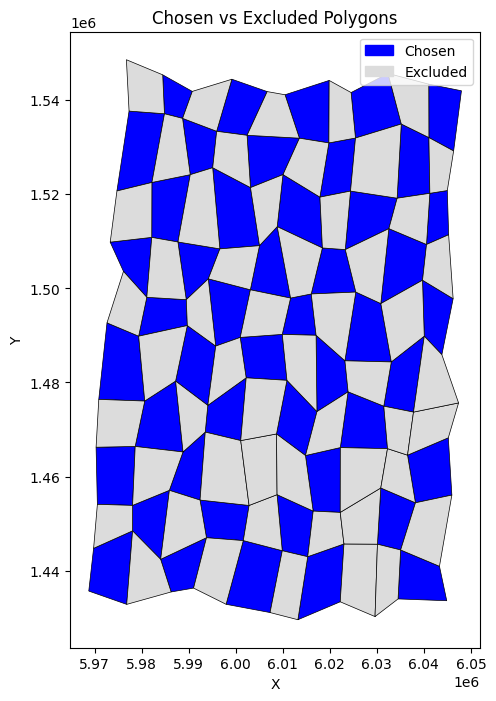

In [235]:
gdf_filtered['chosen'] = gdf_filtered.index.isin(chosen_polygons)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot chosen polygons
gdf_filtered[gdf_filtered['chosen']].plot(ax=ax, color='blue', edgecolor='black', linewidth=0.5, label='Chosen')

# Plot excluded polygons
gdf_filtered[~gdf_filtered['chosen']].plot(ax=ax, color='gainsboro', edgecolor='black', linewidth=0.5, label='Excluded')

chosen_patch = mpatches.Patch(color='blue', label='Chosen')
excluded_patch = mpatches.Patch(color='gainsboro', label='Excluded')
plt.legend(handles=[chosen_patch, excluded_patch])

plt.title('Chosen vs Excluded Polygons')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
